**Data Overview**

This dataset contains 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans.


## **Importing Libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## **1: Data Preprocessing**

### 1.1 Loading the **images**

**Note:-** You need to download data.zip file from this [link](https://drive.google.com/file/d/1GjyA-RaoHb33Sq0EKRvr4-fsA7BNC66U/view?usp=sharing) into folder and then run the next cell.

In [4]:
# for running in kaggle
# Directory containing the extracted data
data_dir = '/kaggle/input/ct-scan-of-covid'

covid_dir = os.path.join(data_dir, '/kaggle/input/ct-scan-of-covid/COVID')
non_covid_dir = os.path.join(data_dir, '/kaggle/input/ct-scan-of-covid/NON-COVID')

covid_images = []
non_covid_images = []

for filename in os.listdir(covid_dir):
    img_path = os.path.join(covid_dir, filename)
    img = Image.open(img_path)
    covid_images.append(img)

for filename in os.listdir(non_covid_dir):
    img_path = os.path.join(non_covid_dir, filename)
    img = Image.open(img_path)
    non_covid_images.append(img)

### **1.2 Resizing images and Normalizing image data**

In [5]:
# Fixed size of (224, 224) for resizing the images
image_size = (224, 224)

# Converting images to RGB mode and resizing them
covid_images = [img.convert('RGB').resize(image_size) for img in covid_images]
non_covid_images = [img.convert('RGB').resize(image_size) for img in non_covid_images]

# Converting the images to arrays and normalizing the pixel values
covid_data = np.array([img_to_array(img)/255.0 for img in covid_images])
non_covid_data = np.array([img_to_array(img)/255.0 for img in non_covid_images])

# Note:- Here covid_data and non_covid_data now contains the preprocessed and normalized image data.

### **2: Data Augmentation**

In [6]:
# Defining all data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,        # Random rotation (±20 degrees)
    width_shift_range=0.2,    # Random horizontal shift (±20% of image width)
    height_shift_range=0.2,   # Random vertical shift (±20% of image height)
    shear_range=0.2,          # Random shear
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True      # Random horizontal flip
)

# Fitting the data augmentation generator on the data
datagen.fit(covid_data)
datagen.fit(non_covid_data)

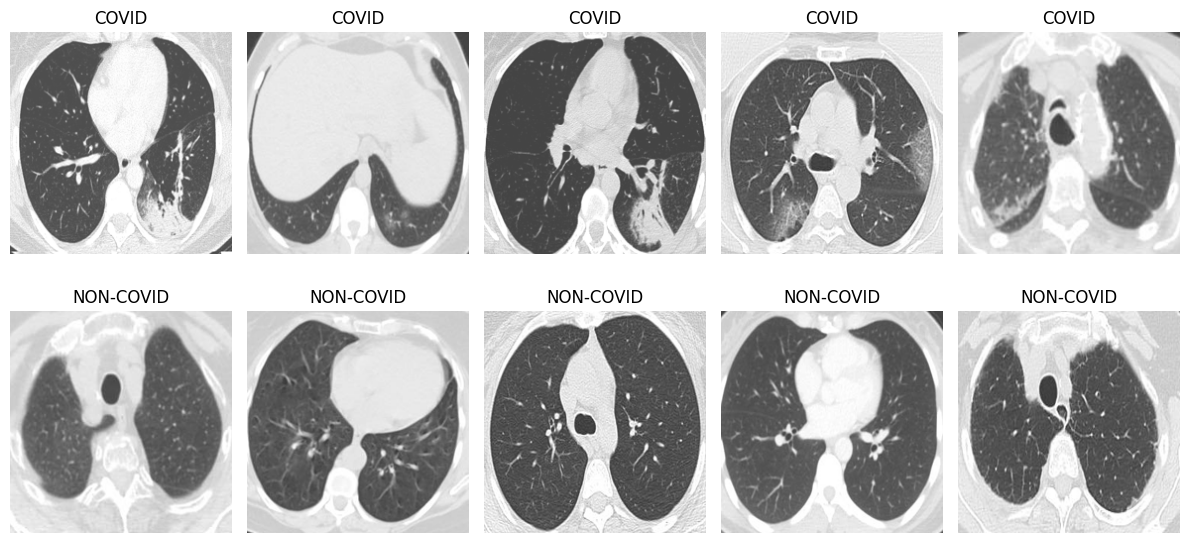

In [7]:
# Display images and count for both Covid and Non Covid class
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(covid_images[i])
    plt.title("COVID")
    plt.axis('off')

for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(non_covid_images[i])
    plt.title("NON-COVID")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Total images in each class

print("Total COVID images:", len(covid_images))
print("Total NON-COVID images:", len(non_covid_images))

Total COVID images: 1252
Total NON-COVID images: 1229


### **3: Data Generator & Train Test Split**

In [9]:
# Combining COVID and non-COVID data and create labels (0 for non-COVID, 1 for COVID)
X = np.concatenate([non_covid_data, covid_data])
y = np.concatenate([np.zeros(len(non_covid_data)), np.ones(len(covid_data))])

# Spliting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating data generators for training and validation
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

In [10]:
# Shapes of the training and validation sets
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1984, 224, 224, 3), (497, 224, 224, 3), (1984,), (497,))

# **4. Model Building**
### 4.1 ResNet50 Model Architecture

In [11]:
# Loading the pre-trained ResNet50 model without the top (classification) layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Adding new layers on top of the ResNet50 base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Creating the final model with our above specified layers
model = Model(inputs=base_model.input, outputs=output_layer)

# Freezing the base ResNet layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [12]:
# Getting Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

# **5: Model Training**
### 5.1: Training the model

In [13]:
# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model using the data generators
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
62/62 [==============================] - 44s 456ms/step - loss: 0.7159 - accuracy: 0.5343 - val_loss: 0.7017 - val_accuracy: 0.5021
Epoch 2/100
62/62 [==============================] - 27s 431ms/step - loss: 0.7097 - accuracy: 0.5292 - val_loss: 0.6814 - val_accuracy: 0.5938
Epoch 3/100
62/62 [==============================] - 27s 433ms/step - loss: 0.7096 - accuracy: 0.5318 - val_loss: 0.6589 - val_accuracy: 0.5938
Epoch 4/100
62/62 [==============================] - 27s 429ms/step - loss: 0.6784 - accuracy: 0.5650 - val_loss: 0.6445 - val_accuracy: 0.6542
Epoch 5/100
62/62 [==============================] - 26s 419ms/step - loss: 0.6684 - accuracy: 0.5872 - val_loss: 0.6667 - val_accuracy: 0.6062
Epoch 6/100
62/62 [==============================] - 26s 426ms/step - loss: 0.6812 - accuracy: 0.5665 - val_loss: 0.6396 - val_accuracy: 0.6396
Epoch 7/100
62/62 [==============================] - 26s 416ms/step - loss: 0.6848 - accuracy: 0.5675 - val_loss: 0.6519 - val_accuracy:

In [14]:
# Loading the best saved model from model checkpoint
best_model = tf.keras.models.load_model('/kaggle/working/best_model.h5')

# Evaluating the model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, batch_size=32)

print("Validation Loss:", val_loss*100)
print("Validation Accuracy:", val_accuracy*100)


# Evaluate the model on the training set
train_loss, train_accuracy = best_model.evaluate(X_train, y_train, batch_size=32)

print("train Loss:", train_loss*100)
print("train Accuracy:", train_accuracy*100)

16/16 [==============================] - 3s 142ms/step - loss: 0.5863 - accuracy: 0.6901
Validation Loss: 58.62778425216675
Validation Accuracy: 69.01408433914185
62/62 [==============================] - 6s 92ms/step - loss: 0.6026 - accuracy: 0.6779
train Loss: 60.25736927986145
train Accuracy: 67.79233813285828


# **6: Model Evaluation and Prediction**
### 6.1 Model Evaluation:

In [15]:
# Load the best saved model
best_model = tf.keras.models.load_model('/kaggle/working/best_model.h5')

# Evaluate the model on the test set
y_pred = best_model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate performance metrics
accuracy = accuracy_score(y_val, y_pred_binary)
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)
conf_matrix = confusion_matrix(y_val, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

16/16 [==============================] - 3s 93ms/step
Accuracy: 0.6901408450704225
Precision: 0.8343949044585988
Recall: 0.5057915057915058
F1 Score: 0.6298076923076923
Confusion Matrix:
 [[212  26]
 [128 131]]


# **7. Fine Tuning our Best Model**

In [16]:
# Unfreezing last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compiling the model again after unfreezing layers
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with fine-tuning
fine_tune_epochs = 60
history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=fine_tune_epochs,
    validation_data=datagen.flow(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate and predict as before
best_fine_tuned_model = load_model('/kaggle/working/best_model.h5')

y_pred_fine = best_fine_tuned_model.predict(X_val)
y_pred_binary_fine = (y_pred_fine > 0.5).astype(int)

accuracy_fine = accuracy_score(y_val, y_pred_binary_fine)
precision_fine = precision_score(y_val, y_pred_binary_fine)
recall_fine = recall_score(y_val, y_pred_binary_fine)
f1_fine = f1_score(y_val, y_pred_binary_fine)
conf_matrix_fine = confusion_matrix(y_val, y_pred_binary_fine)

print("Accuracy (Fine-Tuned):", accuracy_fine*100)
print("Precision (Fine-Tuned):", precision_fine*100)
print("Recall (Fine-Tuned):", recall_fine)
print("F1 Score (Fine-Tuned):", f1_fine)
print("Confusion Matrix (Fine-Tuned):\n", conf_matrix_fine)

Epoch 1/60
62/62 [==============================] - 37s 435ms/step - loss: 0.7908 - accuracy: 0.5368 - val_loss: 3.1893 - val_accuracy: 0.4771
Epoch 2/60
62/62 [==============================] - 26s 416ms/step - loss: 0.6602 - accuracy: 0.5963 - val_loss: 1.9275 - val_accuracy: 0.4750
Epoch 3/60
62/62 [==============================] - 26s 423ms/step - loss: 0.6297 - accuracy: 0.6366 - val_loss: 1.4238 - val_accuracy: 0.4854
Epoch 4/60
62/62 [==============================] - 26s 427ms/step - loss: 0.5999 - accuracy: 0.6719 - val_loss: 0.5948 - val_accuracy: 0.6917
Epoch 5/60
62/62 [==============================] - 26s 420ms/step - loss: 0.5726 - accuracy: 0.7132 - val_loss: 2.4064 - val_accuracy: 0.5188
Epoch 6/60
62/62 [==============================] - 25s 410ms/step - loss: 0.5593 - accuracy: 0.7077 - val_loss: 0.6773 - val_accuracy: 0.6708
Epoch 7/60
62/62 [==============================] - 26s 420ms/step - loss: 0.5582 - accuracy: 0.7097 - val_loss: 1.1481 - val_accuracy: 0.5396

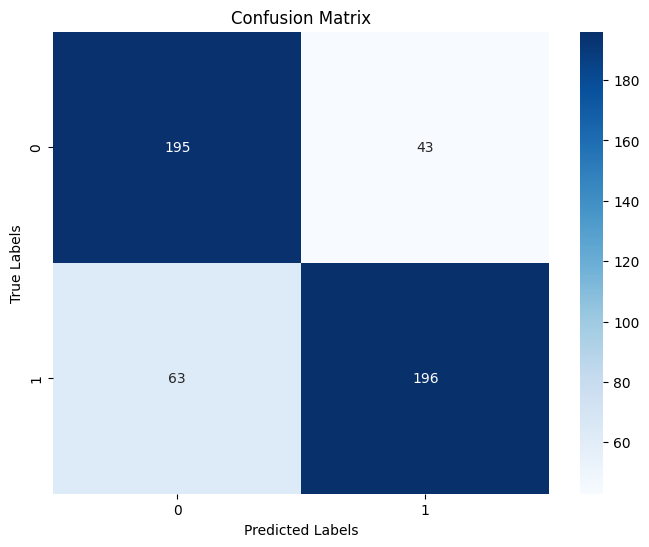

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fine, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Unfreezing last 40 layers for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

# Compiling the model again after unfreezing layers
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model with fine-tuning
fine_tune_epochs = 80
history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=fine_tune_epochs,
    validation_data=datagen.flow(X_val, y_val, batch_size=32),
    validation_steps=len(X_val) // 32,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate and predict as before
best_fine_tuned_model = load_model('/kaggle/working/best_model.h5')

y_pred_fine = best_fine_tuned_model.predict(X_val)
y_pred_binary_fine = (y_pred_fine > 0.5).astype(int)

accuracy_fine = accuracy_score(y_val, y_pred_binary_fine)
precision_fine = precision_score(y_val, y_pred_binary_fine)
recall_fine = recall_score(y_val, y_pred_binary_fine)
f1_fine = f1_score(y_val, y_pred_binary_fine)
conf_matrix_fine = confusion_matrix(y_val, y_pred_binary_fine)

print("Accuracy (Fine-Tuned):", accuracy_fine*100)
print("Precision (Fine-Tuned):", precision_fine*100)
print("Recall (Fine-Tuned):", recall_fine)
print("F1 Score (Fine-Tuned):", f1_fine)
print("Confusion Matrix (Fine-Tuned):\n", conf_matrix_fine)

Epoch 1/80
62/62 [==============================] - 39s 435ms/step - loss: 0.7042 - accuracy: 0.5363 - val_loss: 3.1469 - val_accuracy: 0.5188
Epoch 2/80
62/62 [==============================] - 26s 419ms/step - loss: 0.6661 - accuracy: 0.6018 - val_loss: 0.8655 - val_accuracy: 0.5229
Epoch 3/80
62/62 [==============================] - 26s 410ms/step - loss: 0.6481 - accuracy: 0.6285 - val_loss: 3.1778 - val_accuracy: 0.5208
Epoch 4/80
62/62 [==============================] - 26s 416ms/step - loss: 0.6166 - accuracy: 0.6568 - val_loss: 0.6474 - val_accuracy: 0.6438
Epoch 5/80
62/62 [==============================] - 26s 418ms/step - loss: 0.5848 - accuracy: 0.6850 - val_loss: 1.1343 - val_accuracy: 0.4750
Epoch 6/80
62/62 [==============================] - 26s 414ms/step - loss: 0.5540 - accuracy: 0.7132 - val_loss: 0.8729 - val_accuracy: 0.5938
Epoch 7/80
62/62 [==============================] - 26s 421ms/step - loss: 0.5590 - accuracy: 0.7127 - val_loss: 1.3556 - val_accuracy: 0.4896

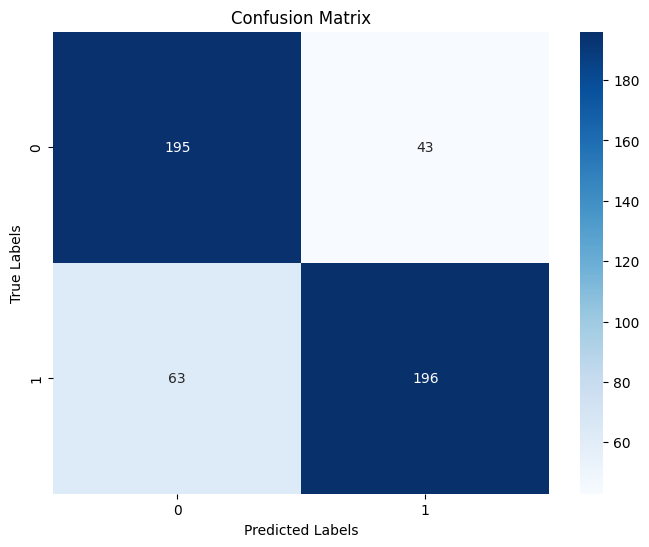

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_fine, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## **Observations**

* After training our ResNet50 model with additional layers like Pooling layers and Dense layers we got an accuracy of **69.014%**.
* After fine tuning our Best Model, we received an accuracy of **78.672%**.

In [20]:
def predict_ct_scan_class(test_image_path, model_path='/kaggle/working/best_model.h5'):
    # Loading the test image
    test_image = Image.open(test_image_path)

    # Performing preprocessing on image
    if test_image.mode == 'RGBA':
        test_image = test_image.convert('RGB')

    # Resize and normalize the test image
    image_size = (224, 224)
    test_image = test_image.resize(image_size)
    test_image_array = np.array(test_image) / 255.0
    test_image_array = np.expand_dims(test_image_array, axis=0)

    # Loading the trained model
    best_model = load_model(model_path)

    # Making the prediction
    prediction = best_model.predict(test_image_array)
    predicted_class = "COVID" if prediction[0][0] > 0.5 else "NON-COVID"

    return predicted_class

In [24]:
test_image_path = '/kaggle/input/test-data/img2.jpg'
predicted_class = predict_ct_scan_class(test_image_path)

print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 961ms/step
Predicted class: COVID
